<a href="https://colab.research.google.com/github/faizasabir/faiza/blob/main/Diabetic_Retinopathy_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install split-folders

## 1. Import Libraries

In [4]:
# !pip install pillow tensorflow keras matplotlib numpy split-folders
import zipfile
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import shutil
from google.colab import files

## 2. Extract the zip

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Diabetic Retinopathy Dataset.zip to Diabetic Retinopathy Dataset.zip


In [6]:
with zipfile.ZipFile('/content/Diabetic Retinopathy Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/raw_data')

## 3. Preprocess and crop images

In [7]:
def process_and_crop_images(input_folder, output_folder, target_size=(150, 150)):
    for category in ['Diabetic Retinopathy', 'No Diabetic Retinopathy']:
        category_path = os.path.join(input_folder, category)
        save_path = os.path.join(output_folder, category)
        os.makedirs(save_path, exist_ok=True)

        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(category_path, filename)
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    min_dim = min(w, h)
                    img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                                    (w + min_dim) // 2, (h + min_dim) // 2))
                    img = img.resize(target_size)
                    img.save(os.path.join(save_path, filename))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

original_data_path = '/content/raw_data'
cropped_data_path = '/content/Processed_Data'
process_and_crop_images(original_data_path, cropped_data_path)

## 4. Split into train/val/test

In [8]:
splitfolders.ratio(cropped_data_path, output="/content/Final_Data", seed=42, ratio=(.8, .1, .1))

Copying files: 3662 files [00:00, 4179.57 files/s]


## 5. Create data generators

In [9]:
train_dir = '/content/Final_Data/train'
val_dir = '/content/Final_Data/val'
test_dir = '/content/Final_Data/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)


Found 2929 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Found 368 images belonging to 2 classes.


## 6. Define CNN model

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train model

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_retinopathy_model.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5641 - loss: 0.7186

92/92 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5651 - loss: 0.7176 - val_accuracy: 0.6822 - val_loss: 0.9093
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8363 - loss: 0.4644

92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8364 - loss: 0.4642 - val_accuracy: 0.8521 - val_loss: 0.3948
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8533 - loss: 0.3958

92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8532 - loss: 0.3957 - val_accuracy: 0.8712 - val_loss: 0.3347
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8596 - loss: 0.3852

92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8597 - loss: 0.3850 - val_accuracy: 0.8849 - val_loss: 0.2772
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8679 - loss: 0.3725 - val_accuracy: 0.8740 - val_loss: 0.3533
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8745 - loss: 0.3444 - val_accuracy: 0.8959 - val_loss: 0.2896
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8699 - loss: 0.3262 - val_accuracy: 0.8959 - val_loss: 0.2879
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8813 - loss: 0.3079

92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8813 - loss: 0.3081 - val_accuracy: 0.9014 - val_loss: 0.2656
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8694 - loss: 0.3148

92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8696 - loss: 0.3147 - val_accuracy: 0.9123 - val_loss: 0.2439
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8848 - loss: 0.2934 - val_accuracy: 0.9014 - val_loss: 0.2814
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8821 - loss: 0.2972

92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8821 - loss: 0.2972 - val_accuracy: 0.9151 - val_loss: 0.2418
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8957 - loss: 0.2866 - val_accuracy: 0.9041 - val_loss: 0.2689
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8993 - loss: 0.2673 - val_accuracy: 0.9068 - val_loss: 0.2951
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9013 - loss: 0.2632 - val_accuracy: 0.9151 - val_loss: 0.2439
Epoch 15/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9037 - loss: 0.2662

92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9037 - loss: 0.2662 - val_accuracy: 0.9233 - val_loss: 0.2250
Epoch 16/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9058 - loss: 0.2531 - val_accuracy: 0.9288 - val_loss: 0.2291
Epoch 17/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9134 - loss: 0.2426 - val_accuracy: 0.8685 - val_loss: 0.3294
Epoch 18/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9007 - loss: 0.2661 - val_accuracy: 0.9205 - val_loss: 0.2746
Epoch 19/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9151 - loss: 0.2672 - val_accuracy: 0.9288 - val_loss: 0.2373
Epoch 20/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9036 - loss: 0.2486 - val_accuracy: 0.9288 - val_loss: 0.2462


## 8. Evaluate model

In [12]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.9248 - loss: 0.2106
Test Accuracy: 92.12%


## 10. Classify local image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


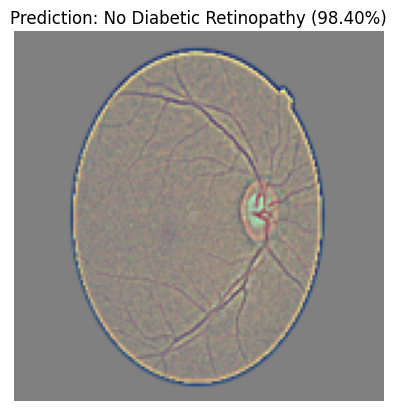

In [13]:
def classify_local_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        min_dim = min(w, h)
        img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                        (w + min_dim) // 2, (h + min_dim) // 2))
        img = img.resize((150, 150))
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        prediction = model.predict(img_array)[0][0]
        label = 'No Diabetic Retinopathy' if prediction > 0.5 else 'Diabetic Retinopathy'
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Prediction: {label} ({confidence*100:.2f}%)')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

classify_local_image('/content/raw_data/No Diabetic Retinopathy/070d4ce5fd90.png')